In [1]:
import os
import pandas as pd
import numpy as np
from collections import Counter
import pickle                
import sys
sys.path.append(os.path.abspath('../../'))

In [2]:
with open('../src/ensembl2genename_GRCh38.85.p', 'rb') as reader:
    gid2gn = pickle.load(reader)

In [3]:
df = pd.read_csv('../../data/gene_info/mart_export_GRCh38.p12.txt',dtype = {'NCBI gene ID':str}, sep = '\t')

entrez2ensembl = {}
for s0, s1 in zip(df['Gene stable ID'], df['NCBI gene ID']):
    if str(s1) != 'nan':
        entrez2ensembl[str(s1)] = str(s0)
        
df_ms = pd.read_csv('../../multiplespecies_network/stab1.csv')

## map ms-genes to ensembl
mg2g = {}
for g, mg in zip(df_ms['Human'], df_ms['Meta-gene']):
    if (' ' in g) or (g == 'No Human gene'): ## multiple genes or not human gene
        continue
    
    
    if str(g) not in entrez2ensembl:
        continue
        
    mg2g[mg] = entrez2ensembl[str(g)]   
    
msgenes = set([g for mg, g in mg2g.items()])

df_ms = pd.read_csv('../../multiplespecies_network/interactions.tab', sep = '\t')

In [4]:
import gwas_component.gwas_component as gc

In [5]:
id2tissue = gc._get_model_name()

In [25]:
from itertools import combinations
from scipy.stats import fisher_exact

path = '../../R_script/WGCNA/'
res = []

for t in id2tissue:
    gmodel = gc.Coexpression_Model(t)
    
    ## common genes in wgcna & multiple-species network
    common_genes = set(gmodel.id2gene) & msgenes  

    ## get multispecies edges between common genes
    elist_ms = set()
    for g1, g2 in zip(df_ms['Meta-gene'], df_ms['Neighbor']):
        
        g1, g2 = str(g1), str(g2)
        
        if g1 == g2:
            continue    
        if (g1 not in mg2g) or (g2 not in mg2g):
            continue
            
        g1, g2 = sorted([mg2g[g1], mg2g[g2]])
        if (g1 not in common_genes) or (g2 not in common_genes):
            continue
            
        g1, g2 = sorted([g1, g2])
        elist_ms.add((g1, g2))       
        
    ## get wgcna edges between common genes
    elist_wgcna = set()
    for _, pc_genes, _, _ in gmodel.pca_models:
        for g1, g2 in combinations(pc_genes, r = 2):
            if g1 == g2:
                continue
            
            if (g1 not in common_genes) or (g2 not in common_genes):
                continue
            
            g1, g2 = sorted([g1, g2])
            elist_wgcna.add((g1, g2))
    
    n_genes = len(common_genes)
    
    n1 = len(elist_ms & elist_wgcna)
    n2 = len(elist_ms - elist_wgcna)
    n3 = len(elist_wgcna - elist_ms)
    n4 = n_genes * (n_genes - 1) / 2 - len(elist_ms | elist_wgcna)
    cmap = [[n1, n2], [n3, n4]]   
    oddr, pval = fisher_exact(cmap, alternative='greater')

    res.append((t, len(elist_ms), len(elist_wgcna), n1, float(n1) / float(len(elist_wgcna)), oddr, pval))


In [26]:
pd.DataFrame(res)

,0,1,2,3,4,5,6
0,Adipose_Subcutaneous,2063,5109,106,0.020748,7.505626,1.128210e-53
1,Adipose_Visceral_Omentum,868,736,22,0.029891,10.172183,4.496511e-15
2,Adrenal_Gland,526,957,41,0.042842,17.291413,7.334605e-35
3,Artery_Aorta,1421,3867,130,0.033618,13.266719,1.028251e-92
4,Artery_Coronary,416,1027,94,0.091529,39.871136,1.177239e-105
5,Artery_Tibial,2167,2237,75,0.033527,11.778069,1.378879e-51
6,Brain_Anterior_cingulate_cortex_BA24,318,835,4,0.004790,1.456184,2.992703e-01
7,Brain_Caudate_basal_ganglia,632,1485,65,0.043771,13.389932,3.216941e-47
8,Brain_Cerebellar_Hemisphere,593,735,17,0.023129,8.298911,1.166830e-10
9,Brain_Cerebellum,1116,1156,52,0.044983,14.948513,5.137995e-41


In [27]:
pd.DataFrame(res)[4].mean(), pd.DataFrame(res)[4].std()

(0.02661597611235342, 0.016286188988738164)

In [28]:
pd.DataFrame(res)[5].max(), pd.DataFrame(res)[5].min()

(39.87113631975927, 1.4561843224723494)

In [10]:
from itertools import combinations
from scipy.stats import fisher_exact

baseline_edges = Counter()

for t in id2tissue:
    gmodel = gc.Coexpression_Model(t)
    common_genes = set(gmodel.id2gene) & msgenes
    for _, pc_genes, _, _ in gmodel.pca_models:
        for g1, g2 in combinations(pc_genes, r = 2):
            if (g1 not in common_genes) or (g2 not in common_genes):
                continue
                
            g1, g2 = sorted([g1, g2])
            baseline_edges[(g1, g2)] += 1

In [12]:
from itertools import combinations
from scipy.stats import fisher_exact

path = '../../R_script/WGCNA/'
res = []

wgcna_edges = Counter()

common_genes_all = set()

for t in id2tissue:
    gmodel = gc.Coexpression_Model(t)
    common_genes = set(gmodel.id2gene) & msgenes
    common_genes_all.update(common_genes)
    
    for _, pc_genes, _, _ in gmodel.pca_models:
        for g1, g2 in combinations(pc_genes, r = 2):
            if (g1 not in common_genes) or (g2 not in common_genes):
                continue
                
            g1, g2 = sorted([g1, g2])
            wgcna_edges[(g1, g2)] += 1

In [13]:
## get multispecies edges between common genes
elist_ms = set()
for g1, g2 in zip(df_ms['Meta-gene'], df_ms['Neighbor']):
    g1, g2 = str(g1), str(g2)
    if g1 == g2:
        continue    
    if (g1 not in mg2g) or (g2 not in mg2g):
        continue

    g1, g2 = mg2g[g1], mg2g[g2]
    if (g1 not in common_genes_all) or (g2 not in common_genes_all):
        continue

    g1, g2 = sorted([g1, g2])
    elist_ms.add((g1, g2))

In [14]:
len(elist_ms)

10392

In [15]:
count2edges = {i:set() for i in range(15)}
for e, c in wgcna_edges.most_common():
    count2edges[c].add(e)

In [16]:
res = []
for i in range(14, 0, -1):
    s1 = count2edges[i]
    n1, n2 = len(s1), len(s1 & elist_ms)
    #print i, n1, n2, float(n2) / float(n1)
    res.append((i, n1, n2, float(n2) / (float(n1) + 1e-7)))

In [17]:
pd.DataFrame(res)

,0,1,2,3
0,14,1,0,0.000000
1,13,1,1,1.000000
2,12,7,2,0.285714
3,11,9,5,0.555556
4,10,12,4,0.333333
5,9,19,8,0.421053
6,8,28,15,0.535714
7,7,33,14,0.424242
8,6,43,14,0.325581
9,5,75,20,0.266667


In [16]:
import networkx as nx
gnx = nx.Graph()

In [17]:
gnx.add_edges_from([(gid2gn[n1], gid2gn[n2]) for (n1, n2), c in wgcna_edges.items() if c > 3])

In [18]:
len(gnx.nodes)

166

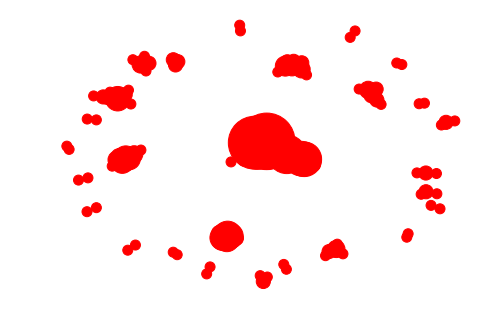

In [19]:
import matplotlib.pyplot as plt
% matplotlib inline

pos=nx.spring_layout(gnx)

d = dict(gnx.degree)

nx.draw(gnx, pos=pos, nodelist=d.keys(), node_size=[v * 100 for v in d.values()])
plt.show()


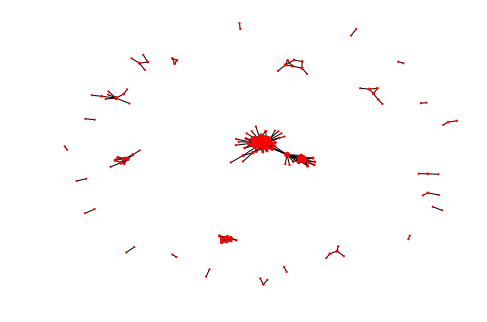

In [20]:
nx.draw(gnx, pos=pos, nodelist=d.keys(), node_size=[v * 1.5 for v in d.values()])
plt.show()

In [21]:
sgs = sorted(nx.connected_component_subgraphs(gnx), key =lambda x: len(x), reverse = True)

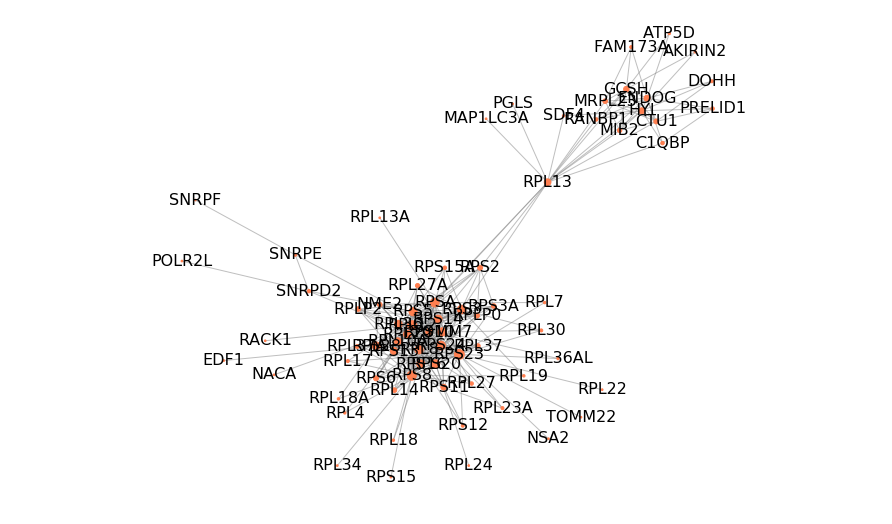

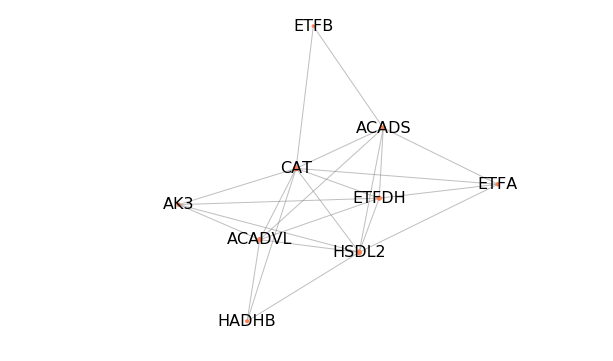

In [71]:
for i, sg in enumerate(sgs[:2]):
    #for s in sg.nodes():
    #    print s
    if i == 0:
        fig = plt.figure(figsize = (15, 9))
    elif i == 1:
        fig = plt.figure(figsize = (10, 6))
        
    pos=nx.spring_layout(sg)
    d = dict(sg.degree)
    #nx.draw_networkx_nodes(sg, pos=pos, nodelist=d.keys(), node_size=[v for v in d.values()])
    nx.draw_networkx_nodes(sg, pos=pos, nodelist=d.keys(),
                           node_size=[v * 3 for v in d.values()], 
                           node_color='#FF7F50')
    nx.draw_networkx_edges(sg, pos, width=1.0, edge_color='gray', alpha=0.5, )
    
    nx.draw_networkx_labels(sg, pos, font_size=16)
    plt.xlim([-1.1, 1.1])
    plt.axis('off')
    plt.show()

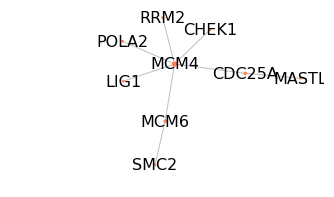

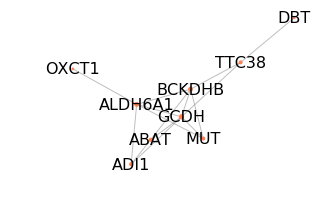

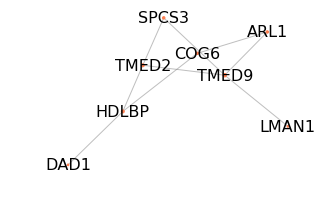

In [75]:
for i, sg in enumerate(sgs[2:5]):
    fig = plt.figure(figsize = (5, 3))
    pos=nx.spring_layout(sg)
    d = dict(sg.degree)
    #nx.draw_networkx_nodes(sg, pos=pos, nodelist=d.keys(), node_size=[v for v in d.values()])
    nx.draw_networkx_nodes(sg, pos=pos, nodelist=d.keys(),
                           node_size=[v * 3 for v in d.values()], 
                           node_color='#FF7F50')
    nx.draw_networkx_edges(sg, pos, width=1.0, edge_color='gray', alpha=0.5, )
    
    nx.draw_networkx_labels(sg, pos, font_size=16)
    plt.xlim([-1.2, 1.2])
    plt.axis('off')
    plt.show()

In [34]:
nx.write_graphml?

In [43]:
cytodata = nx.readwrite.json_graph.cytoscape_data(sgs[0])

In [44]:
import json
with open('network.json', 'w') as outfile:  
    json.dump(cytodata, outfile)